The whole notebook should take aruond 15 minutes to run. All the results are already printed. Feel free to skip the running and the code cells as all the content is present in Markdown cells and printed text/images. 

# Intro

In this notebook we will load the saved dataframes form the "Initial_study.ipynb" and prepare a training set for the model. Here I start by adding some useful columns and labelling cases.

At the moment the dataset can be divided in the following classes :

- Evicted Contracts : Type_1 or Type_2
- Perfect Contracts : contracts with no delay_fee ever paied
- Closed Contract : contracts that where closed without eviction
- Unlabeled Tenants : None of the above

This distinction already provide us a quite large portion of labels:

- Evicted contracts: 315 (2 %)
- Perfect contracts: 6094 (54 %)
- Closed contracts: 1835 (16 %)
- Unlabeled contracts: 4024 (36 %)

From the distributions, it is clear this is an unbalanced training set. Few methods are avaliable to deal with unbalance problems, here we will include wights to the model. Moreover, we would expect that most tenants will not be evicted, so we would hope to find a similar distribution of cases when looking at new contracts/tenants. Later on we will show how precision and recall will provide us with a clearn metric for deciding if our ML-model is accurate for negative and positive classes.

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import pandas as pd
import datetime
import calendar
import time
import gender_guesser.detector as gender
import PIL
from PIL import Image
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from datetime import date, timedelta

# ML imports
from sklearn import preprocessing
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
import keras_metrics
import keras
from keras.layers import Input, Embedding
from keras.utils.vis_utils import plot_model
from keras.models import Model

# to print without code the notebook use
# jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True Learning_Notebook.ipynb

# useful functions
d = gender.Detector()
flatten = lambda l: [item for sublist in l for item in sublist]

Using TensorFlow backend.


In [2]:
# Load Data
# Here the basic info about dataset size, missing entries and date range
# I also change the time of dates to datetime for manipulation ease

contracts=pd.read_csv('contracts_updated.csv')
contracts['contract_start']=pd.to_datetime(contracts['contract_start'])
contracts['contract_end']=pd.to_datetime(contracts['contract_end'])
print('tot_num_contracts:',len(contracts['contract_id'].unique()))

transactions=pd.read_csv('transactions_updated.csv')
transactions['Payment_date']=pd.to_datetime(transactions['Payment_date'])
transactions['delay']=[int(i.split()[0]) for i in transactions['delay'].fillna('-100')]
transactions['delay']=transactions['delay'].replace(-100,np.nan)
rent_map=contracts.set_index('contract_id')['rent'].to_dict()
transactions['rent']=transactions['contract_id'].map(rent_map)
transactions['delay_fee']=transactions['Amount']-transactions['rent']

#deposits
transactions['deposit']=(transactions['index_history_contract']==0)&\
             (transactions['delay']==0)&\
             (transactions['delay_fee']>0)
#refunts
transactions['refund']=(transactions['delay_fee']<0)
#rent
transactions['rent_pay']=~((transactions['refund'])|(transactions['deposit']))
transactions.loc[transactions['refund']==True,'rent_pay']=False
transactions.loc[transactions['Amount'].isnull(),'rent_pay']=False

transactions.loc[transactions['refund']==True,'delay_fee']=transactions['rent']*3+transactions['Amount']
transactions.loc[transactions['deposit']==True,'delay_fee']=0

print('tot_num_transaction:',len(transactions))
max_length=max(transactions['index_history_tenant'])+1
print('longest tenant history',max_length)

# Last and firt date of transaction in the database
first_date=sorted(transactions['Payment_date'])[0]
print('Earliest Date recorded:',first_date)
last_date=sorted(transactions['Payment_date'])[-1]
print('Latest Date recorded:',last_date)

# Contracts without transactions/ Transactions without Contract info
all_con_t=set(transactions['contract_id'])
all_con_c=set(contracts['contract_id'])
missing_in_t=all_con_c-all_con_t
print('missing_in_transactions:',len(missing_in_t))
missing_in_c=all_con_t-all_con_c
print('missing_in_transactions:',len(missing_in_c))

# These functions will be very handy for clean and fast manipulation of the database
# adds a month to a datetime type
def add_months(sourcedate, months):
    '''adds a month to a datetime type'''
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

# gets contracts associated with a tenant using tenant_id
def get_contracts(tenant,contracts=contracts,transactions=transactions):
    '''
    Gets contracts associated with a tenant using tenant_id
    A list of tenants may also be passed.
    '''
    if type(tenant)==str:
        tenant=[tenant]
    df=contracts[contracts['tenant_id'].isin(tenant)].reset_index(drop=True)
    return df

# gets hisory of transitions for a speacific contract using contract_id
def get_history(contract,contracts=contracts,transactions=transactions):
    '''
    Gets hisory of transitions for a speacific contract using contract_id.
    A list of contracts may also be passed.
    '''
    if not type(contract)==list:
        contract=[contract]
    df=transactions[transactions['contract_id'].isin(contract)].reset_index(drop=True)
    return df

# gets tenant associated with a contract using contract_id
def get_tenant(contract,contracts=contracts,transactions=transactions):
    '''
    Gets tenant associated with a contract using contract_id
    '''
    df=tenants[tenants['c_ids'].apply(lambda x: contract in x)]
    return df
 
# gets contract info from contract.csv dataframe using contract_id
def get_cinfo(contract,contracts=contracts,transactions=transactions):
    '''
    Gets contract info from contract.csv dataframe using contract_id
    A list of contracts may also be passed.
    '''
    if not type(contract)==list:
        contract=[contract]
    df=contracts[contracts['contract_id'].isin(contract)].reset_index(drop=True)
    return df


map_t=dict()
for tenant in contracts['tenant_id'].unique():
    t_contracts=list(get_contracts(tenant)['contract_id'])
    for t in t_contracts:
        map_t[t]=tenant
map_c = defaultdict(list)
for key,value in map_t.items():
    map_c[value].append(key)

tot_num_contracts: 11165
tot_num_transaction: 268853
longest tenant history 43
Earliest Date recorded: 2014-12-02 00:00:00
Latest Date recorded: 2017-12-31 00:00:00
missing_in_transactions: 0
missing_in_transactions: 0


## Classes before training

I defined "perfect tenants" those tenants that never paid a fee for a delay. As we will see below, this means that they never delaied a payment more than 2 days. Later we will relax the labelling as we could include a brother class of good tenants (but not perfect) into our training set.

In [3]:
# perfect guys
perfect_contracts=transactions.groupby('contract_id').agg({'delay_fee':['sum','mean', 'max','std']})
perfect_contracts=list(set(perfect_contracts[perfect_contracts['delay_fee']['sum']<1].index))
evicted_contracts=list(contracts[~contracts['eviction'].isna()]['contract_id'])
# Gather contracts that have been closed without eviction
medium_con=list(contracts[(contracts['eviction'].isna())
         &(~contracts['contract_end'].isna())]['contract_id'])

contracts['perfect']=contracts['contract_id'].isin(perfect_contracts)

# GENDER
names_gender=[]
for name in contracts['name']:
    names_gender.append(d.get_gender(name))
contracts['gender']=names_gender

print('perfect contracts:',len(perfect_contracts))
print('closed contracts:',len(medium_con))
print('evicted contracts:',len(evicted_contracts))
print('unlabeled contracts:',len(set(contracts['contract_id'])-\
                                set(perfect_contracts)-\
                                set(medium_con)-\
                                set(evicted_contracts)))

perfect contracts: 6094
closed contracts: 1835
evicted contracts: 315
unlabeled contracts: 4024


### General notes on possible improvements

Possible features for the model:

- Consider seniority of Tenant (e.g. tenant with long history of rent and no evictions)
- Consider Age of tenant
- Consider Gender of tenants
- Consider Location of contract
- Consider difference in previous tenant rent (increase rent may lead to eviction)
- Consider Payment method (how many, and which are relevant for classify tenants)
- Consider time of the year (tenants that behave well during an expansive time of the year, for instance winter time)



### Note on Age

As we could imagine, age will determine the behaviour of the tenant. form the below statistics we see that ages are well distributed in the dataset, but evictions cases are reduced after 40s and before 70s. It is possible that yonger people will be prone to be late with payment, and seniors are probably prone to pass away and forget to pay their rent.

In [4]:
contracts['age']=2018-contracts['dob'].apply(lambda x: int(x[:4]))
print('Age range:',max(contracts['age'])-min(contracts['age']),'years') # age span

Age range: 43 years


Contracts Age Distribution


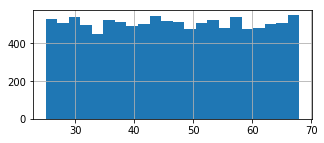

In [5]:
print('Contracts Age Distribution')
_=contracts['age'].hist(figsize=(5,2),bins=22)

Perfect Tenants Age Distribution


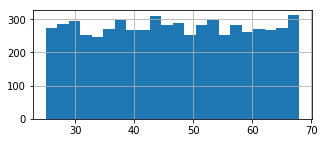

In [6]:
print('Perfect Tenants Age Distribution')
_=contracts[contracts['perfect']==True]['age'].hist(figsize=(5,2),bins=22)

Evicted Tenants Age Distribution


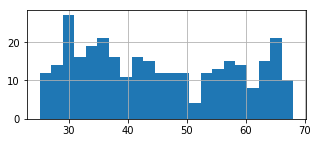

In [7]:
print('Evicted Tenants Age Distribution')
_=contracts[~contracts['eviction'].isna()]['age'].hist(figsize=(5,2),bins=22)

Evicted Tenants Age Distribution: Type_1 in blue | Type_2 in orange


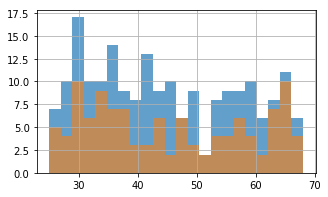

In [8]:
print('Evicted Tenants Age Distribution: Type_1 in blue | Type_2 in orange')
_=contracts[contracts['eviction']=='Type_1']['age'].hist(figsize=(5,3),alpha=0.7,bins=22)
_=contracts[contracts['eviction']=='Type_2']['age'].hist(figsize=(5,3),alpha=0.6,bins=22)

# Note on delay Fees

It is possible to notice that when the tenant are late for a payment, they will received a fee on top of their starndard rent fee. Here I check the possible percentages of delay_fee associated with the delay. What I found is that the whole dataframe follows the rule printed below. 

- Percentage fee: 5 % (22721 transactions) from 3.0 to 7.0 days of delay
- Percentage fee: 10 % (9721 transactions) from 8.0 to 14.0 days of delay
- Percentage fee: 20 % (5769 transactions) from 15.0 to 30.0 days of delay
- Percentage fee: 50 % (1408 transactions) from 31.0 to 61.0 days of delay

In [9]:
# fees percentages with respect to the rent
temp=transactions[(transactions['delay']>0)&(transactions['rent_pay']==True)][['delay','delay_fee','rent']]
temp['precent']=((temp['delay_fee'].fillna(0)/temp['rent'])*100).astype(int)
for per in sorted(temp['precent'].unique())[1:]:
    asd=temp[temp['precent']==per]['delay']
    print('Percentage fee:',per,'%',"({} cases)".format(len(asd)))
    print('from',min(asd),'to',max(asd),'days')

Percentage fee: 5 % (22721 cases)
from 3.0 to 7.0 days
Percentage fee: 10 % (9721 cases)
from 8.0 to 14.0 days
Percentage fee: 20 % (5769 cases)
from 15.0 to 30.0 days
Percentage fee: 50 % (1408 cases)
from 31.0 to 61.0 days


# Note on evictions

Another point to be checked is wether the evictions of the two tipes have different distribution in delays with respect to the rest of the dataset. Below the statistics show that clearly evicted tenant accumulate many days of delay (Type_2 more thant Type_1 on average) and the mean delay between evictions and no-evictions is strongly significant:

- Eviction Type1 Averages

    - delay  sum     188.00
    - delay       mean     13.36
    - delay       max      37.91
    - delay       std      13.18
- Eviction Type2 Averages

    - delay  sum     230.75
    - delay     mean     14.40
    - delay    max      43.70
    - delay    std      14.26
- No eviction Averages

    - delay  sum     34.05
    - delay       mean     1.32
    - delay       max      6.89
    - delay       std      1.86    
- No eviction & Not perfect Averages 

    - delay  sum     77.15
    - delay        mean     2.99
    - delay       max     15.47
    - delay        std      4.11
- Perfect Averages

    - delay  sum     0.41
    - delay      mean    0.01
    - delay       max     0.20
    - delay      std     0.11

In [10]:
print('Eviction Type1 Averages')
type_1=contracts[contracts['eviction']=='Type_1']['contract_id']
print(transactions[transactions['contract_id'].isin(type_1)]\
.groupby('contract_id').agg({'delay':['sum','mean', 'max','std']}).mean())

print('Eviction Type2 Averages')
type_2=contracts[contracts['eviction']=='Type_2']['contract_id']
print(transactions[transactions['contract_id'].isin(type_2)]\
.groupby('contract_id').agg({'delay':['sum','mean', 'max','std']}).mean())

print('No eviction Averages')
type_na=contracts[contracts['eviction'].isna()]['contract_id']
print(transactions[transactions['contract_id'].isin(type_na)]\
.groupby('contract_id').agg({'delay':['sum','mean', 'max','std']}).mean())

print('No eviction & Not perfect Averages')
type_na=contracts[contracts['eviction'].isna()&(contracts['perfect']==False)]['contract_id']
print(transactions[transactions['contract_id'].isin(type_na)]\
.groupby('contract_id').agg({'delay':['sum','mean', 'max','std']}).mean())

print('Perfect Averages')
type_na=contracts[contracts['eviction'].isna()&(contracts['perfect']==True)]['contract_id']
print(transactions[transactions['contract_id'].isin(type_na)]\
.groupby('contract_id').agg({'delay':['sum','mean', 'max','std']}).mean())

Eviction Type1 Averages
delay  sum     188.004975
       mean     13.364007
       max      37.915423
       std      13.184556
dtype: float64
Eviction Type2 Averages
delay  sum     230.754386
       mean     14.408209
       max      43.701754
       std      14.260879
dtype: float64
No eviction Averages
delay  sum     34.053733
       mean     1.322745
       max      6.897604
       std      1.865982
dtype: float64
No eviction & Not perfect Averages
delay  sum     77.150336
       mean     2.993945
       max     15.478343
       std      4.112867
dtype: float64
Perfect Averages
delay  sum     0.419429
       mean    0.018474
       max     0.200853
       std     0.112424
dtype: float64


## Note on payment methods

As we have seen before most tenants use direct debits and bank transfer. Most of the tenants keep their payment method unique. As we are in search of more features for the training, it may be of interest to look to the payment methods of evicted tenants compared with perfect tenants.

From the cells below we see that evicted tenants have higher rate of using 2 paying methods (23%) compared to perfect tenants (0.1%). Moreover, also the type of payment changes between the two categories:

- Evicted
    - Direct debit : 62.7 %
    - Cash : 25.7 %
    - Bank Transfer: 11.5 %
- Perfect Tenants
    - Direct debit : 80.2 %
    - Cash : 5.0 %
    - Bank Transfer: 14.6 %

In [11]:
# SLOW CELL
pay_method_used=[]
for con  in contracts['contract_id']:
    pay_method_used.append(Counter(get_history(con)['payment_method']))
contracts['Payment_method']=pay_method_used

In [12]:
# evictions payments methods
print('Evictions')
print(Counter(contracts[~contracts['eviction'].isna()]['Payment_method'].apply(len)))
print(Counter(flatten(list(contracts[~contracts['eviction'].isna()]['Payment_method']\
                     .apply(lambda x: list(x.keys()))))))

print('Perfect Tenants')
# perfect payments methods
print(Counter(contracts[contracts['perfect']==True]['Payment_method'].apply(len)))
print(Counter(flatten(list(contracts[contracts['perfect']==True]['Payment_method']\
                     .apply(lambda x: list(x.keys()))))))

Evictions
Counter({1: 241, 2: 74})
Counter({'DIRECT_DEBIT': 244, 'CASH': 100, 'BANK_TRANSFER': 45})
Perfect Tenants
Counter({1: 6084, 2: 10})
Counter({'DIRECT_DEBIT': 4901, 'BANK_TRANSFER': 894, 'CASH': 309})


In [13]:
methods=['DIRECT_DEBIT','BANK_TRANSFER','CASH']
direct=contracts['Payment_method'].apply(lambda x: x[methods[0]]).rename('DIRECT_DEBIT')
transf=contracts['Payment_method'].apply(lambda x: x[methods[1]]).rename('BANK_TRANSFER')
cash=contracts['Payment_method'].apply(lambda x: x[methods[2]]).rename('CASH')
pay_df=pd.concat([contracts['contract_id'],direct,transf,cash],axis=1)
# ADD PAYMENT FEATURES IN CONTRACT DF
contracts['DIRECT_DEBIT']=[a['DIRECT_DEBIT'] for a in contracts['Payment_method']]
contracts['CASH']=[a['CASH'] for a in contracts['Payment_method']]
contracts['BANK_TRANSFER']=[a['BANK_TRANSFER'] for a in contracts['Payment_method']]
contracts['num_payment_method']=[len(a) for a in contracts['Payment_method']]

## Note on number of contracts

As for payment methods, we could expect the amount of contracts to be a relevant feature for the two classes. In the below cell I computed the number of contract for each tenants and counted the cases. 

In [14]:
print('Evicted tenants num_contracts percentages')
print('1 contract',round(303/(303+11+1),2),
      '|| 2 contracts',round(11/(303+11+1),2),
      '|| 3 contracts',round(1/(303+11+1),2))
print('Perfect tenants num_contracts percentages')
print('1 contract',round(4649/(4649+785+48+1),2),
      '|| 2 contracts',round(785/(4649+785+48+1),2),
    '|| 3 contracts',round(48/(4649+785+48+1),2))

Evicted tenants num_contracts percentages
1 contract 0.96 || 2 contracts 0.03 || 3 contracts 0.0
Perfect tenants num_contracts percentages
1 contract 0.85 || 2 contracts 0.14 || 3 contracts 0.01


In [15]:
# Numbers of contracts

print('Evicted tenants num_contracts')
num_con=[]
for tenant in set(contracts[~contracts['eviction'].isna()]['tenant_id']):
    num_con.append(len(get_contracts(tenant)))
print(Counter(num_con))

print('Perfect tenants num_contracts')
num_con=[]
for tenant in set(contracts[contracts['perfect']==True]['tenant_id']):
    num_con.append(len(get_contracts(tenant)))
print(Counter(num_con))

Evicted tenants num_contracts
Counter({1: 303, 2: 11, 3: 1})
Perfect tenants num_contracts
Counter({1: 4649, 2: 785, 3: 48, 4: 1})


## Note on gender

An additional information we have about the tenat is gender. By using a python library we can gess the gender from the name of the tenat and look at which gender gets evicted the most. I would have expected more male evicted tenants, but the dataset seems very balanced, and statistics do not show that this feature would be a strong classifier for training. Moreover, some ethical biases question could arise by using this fature.

In [16]:
print('Perfect Tenants')
display(Counter(contracts[contracts['perfect']==True]['gender']))
print('Evicted Tenants')
display(Counter(contracts[~(contracts['eviction'].isna())]['gender']))

Perfect Tenants


Counter({'female': 2493,
         'male': 2488,
         'unknown': 568,
         'mostly_male': 310,
         'mostly_female': 157,
         'andy': 78})

Evicted Tenants


Counter({'unknown': 27,
         'female': 129,
         'male': 134,
         'mostly_male': 14,
         'mostly_female': 7,
         'andy': 4})

In [17]:
# Saves full df in case of modifications
# Necessary for time dependent analysis
all_contracts=contracts.copy()
all_transactions=transactions.copy()

# TRAINING

As benchmark, we are going to train a RNN with a LSMT cell, and a dropout layer to avoid overfitting.
The choice is clear for the time-series problem point of view. Moreover, Using an LSMT we dont have to worry (for a start) to pad the time series with zeros. The model will learn to not consider the first entries equal to zero and look at delay values that show a bad-tenant behaviour. From all the data we have, the most relevant information is clearly the past payment history for each tenant, and more specificly delays. Both delays_fees and Amount are simply correlated to the delay feature and would not add information (if not make worse) our model. 

Additionally we have information about features that could be relevant to distinguish tenants behaviour:

- Number of Contracts
- Number of transactions
- Payment Methods (which and/or how many)
- Age
- Gender
- Last recorded payment (to date)

Below we define a function to train the model. We will print the model to have a visualization of the graph. There is a series of paramenters in the model that are currently set with sensible guesses. These can be selected by hyperparameter selection once the benchmark model is established. These parameters are:

- LSMT output size
- Epochs 
- Batch size
- Dropout size
- Dense layers output size (for each dense layer)
- Numbers of dense layers
- Loss
- Optimizer

Moreover, I define a preprocessing function to make sure the training data is clean and in the right shape for the model input.

For all the models I will use precision and recall as my metrics (combined into the F-score). Accuracy itself is not a reliable metric as the classes are strongly unbalanced. Moreover, I will use the somewhat standard adam optimizer and categorical_crossentropy as a loss function. The main challenge of this training will be the to choose a training set and the way features/time-series are combined. Notice that all the models provide two outputs, one for the positive and one for the negative classification. When plotting, I will show the difference between the positive and the negative value. A value near -1 shows a strong classification for a bad contract/tenant, and a value near 1 for a good contract/tenant.

### Model 1

We train the model using only perfect and eviction contracts. This classifier is not going to be good for average cases, where a tenant has some delays but is actually closing its contracts positivelly. The only feature is delay history.

### Model 2

We train the model with closed contracts within the range period of the dataset (evicted as negative, non evicted as positive). This classes are more diverse and may lead to less overfitting model. The only feature is delay history.

### Model 3

Going further with adding features, we need to modify our graph so to mearge the output of the LSMT with other features (Number of Contracts, Payment Methods number, Payment Methods types, Age, Gender, ...). I print the graph so to have a clear visualization of its structure. Here more feature selection would be needed and more complex achitecture could be implemented.

### Model 4

I include some more labels in the training set by using unsupervised learning, prior to to the NN training. Using this method I can label most of the data at hand (~75% of tenants)

### Model 5

We consider a time dependet model, where we specify the presente date and we can only train with information prior to that date. The training set gets smaller and we will be less informed about tenants behaviour.



NOTICE: All the models contain a dropout layer, this means that the training accuracy and training loss (and F_score) will be worse than the validation ones. This is simply because Keras uses dropout when checking on training but does not on validation. If we where to set the parameter drop_out=0 then validation metrics will appear worse than training one.



### Model functions definition

In [18]:
# MODEL function
# fit and evaluate a model
def evaluate_model(trainX, trainy,
    verbose= 0,
    lsmr_para=20,
    epochs=50,
    batch_size=64,
    drop_out=0.5,
    dense_size=100,
    dense_layer_num=2,
    val_split=0.2,
    loss='categorical_crossentropy',
    optimizer='adam'):

    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(lsmr_para, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(drop_out))
    for _ in range(dense_layer_num):
        model.add(Dense(dense_size, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss=loss, optimizer=optimizer,
                  metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall()])
    # fit network
    classes_in=sum(trainy)
    weight=classes_in[0]/classes_in[1]
    
    history = model.fit(trainX, trainy, 
                        epochs=epochs,
                        validation_split=val_split,
                      batch_size=batch_size,
                      class_weight={0: 1.,1: weight},
                      verbose=verbose)
    # evaluate model
    #_, accuracy ,precision, recall = model.evaluate( batch_size=batch_size, verbose=0)
    return history, model #, accuracy ,precision, recall

In [19]:
# PREPROCESSING functions
def get_train_set(pos_contracts,neg_contracts,
                  unused_p_len=200,unused_n_len=100):
   
    train=[]
    
    # keeping some negative contracts at hand to test the model
    unused_neg=neg_contracts[-unused_n_len:]
    # keeping some positive contracts at hand to test the model
    unused_pos=pos_contracts[-unused_p_len:]

    for con in neg_contracts[:-unused_n_len]:
        hist=get_history(con)
        hist=list(hist[hist['rent_pay']==True]['delay'])[:-2]
        b= [0] * (max_length - len(hist))
        hist=b+hist
        hist=hist+[True]
        train.append(hist)

    for con in pos_contracts[:-unused_p_len]:
        hist=get_history(con)
        hist=list(hist[hist['rent_pay']==True]['delay'])
        b= [0] * (max_length - len(hist))
        hist=b+hist
        hist=hist+[False]
        train.append(hist)

    df_train=pd.DataFrame(train)
    acc=[]
    label_key=df_train.keys()[-1]
    
    #Shuffle
    evic=df_train[df_train[label_key]==True].sample(frac=1)
    noevic=df_train[df_train[label_key]==False].sample(frac=1)

    xtrain=pd.concat([evic,noevic]).sample(frac=1)
    ytrain= xtrain[label_key].values
    ytrain = to_categorical(ytrain)

    xtrain=xtrain.drop(label_key,axis=1).values
    xtrain=np.expand_dims(xtrain, axis=2)
    
    return xtrain, ytrain, unused_neg, unused_pos

# EVALUATION function
def check_contracts(contracts,
                    min_ran=max_length,
                    max_ran=max_length):
    check=[]
    # Checks contract classification
    for ran in range(min_ran,max_ran+1):
        predictions=[]
        for i in range(len(contracts)):
            try:
                temp=get_history(contracts[i])
                temp=temp[temp['rent_pay']==True]
                temp=list(temp['delay'])[:ran]
                x_pred=[0]*(max_length-len(temp))+temp
                x_pred=np.expand_dims(np.expand_dims(x_pred, axis=0), axis=2)
                predictions.append(model.predict(x_pred))
            except Exception as e: 
                print(e)
                continue
        check=[predictions[i][0][0]-predictions[i][0][1] for i in range(len(predictions))]
        print('After ',ran,' months')
        print('Positive:',sum([a>0 for a in check]),'Negative:',sum([a<0 for a in check]))
        uncl_num=len(contracts)-(sum([a>0 for a in check])+sum([a<0 for a in check]))
        if uncl_num:
            print('Unclassified:',uncl_num)
        plt.figure(figsize=(3,1))
        _,_,_=plt.hist(check)
        plt.show()
    
    return check
def plot_hist(metric):
    plt.figure(figsize=(6,3))
    plt.plot(history.history[metric])
    try:
        plt.plot(history.history['val_'+metric])
    except:
        pass
    plt.title('model {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()
    
def plot_f_score(history):
    plt.figure(figsize=(6,3))
    pre=np.array(history.history['precision'])
    rec=np.array(history.history['recall'])
    plt.plot(list(2*(pre*rec)/(pre+rec)))
    pre=np.array(history.history['val_precision'])
    rec=np.array(history.history['val_recall'])
    plt.plot(list(2*(pre*rec)/(pre+rec)))
    plt.title('F score')
    plt.xlabel('epoch')
    plt.legend(['train', 'Validation'], loc='upper left')
    plt.show()
    

### Model 1 

In [20]:
# SLOW CELL - Preprocess of training data and check dimentions
[xtrain, ytrain, unused_neg, 
 unused_pos]=get_train_set(perfect_contracts,evicted_contracts)
print(xtrain.shape, ytrain.shape, len(unused_neg), len(unused_pos))

(6109, 43, 1) (6109, 2) 100 200


In [21]:
history, model = evaluate_model(xtrain,ytrain)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


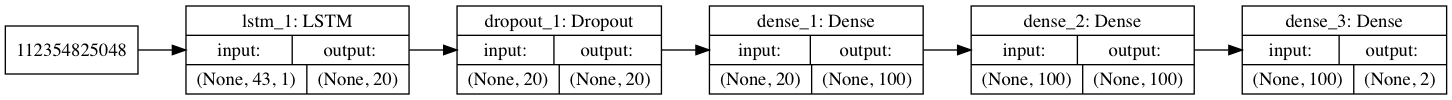

In [22]:
# Visualization of Model_1

plot_model(model, to_file='model_1_plot.png', show_shapes=True, show_layer_names=True,rankdir='LR')
img=Image.open('model_1_plot.png')
img

Negative Test Set
After  43  months
Positive: 4 Negative: 96


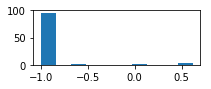

Positive Test Set
After  43  months
Positive: 199 Negative: 1


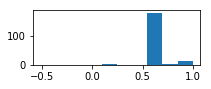

Closed contracts predictions
After  43  months
Positive: 1254 Negative: 581


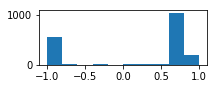

Unlabeled contracts predictions
After  43  months
Positive: 1241 Negative: 3515


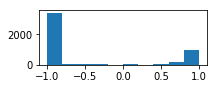

In [23]:
np.warnings.filterwarnings('ignore')
print('Negative Test Set')
_=check_contracts(unused_neg)
print('Positive Test Set')
_=check_contracts(unused_pos)
print('Closed contracts predictions')
_=check_contracts(medium_con)
print('Unlabeled contracts predictions')
unlabeled_contracts=list(set(contracts['contract_id'])\
                         -set(perfect_contracts)-set(evicted_contracts))
check=check_contracts(unlabeled_contracts)

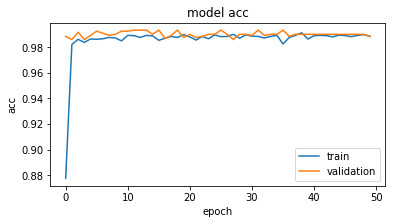

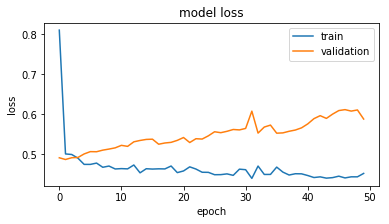

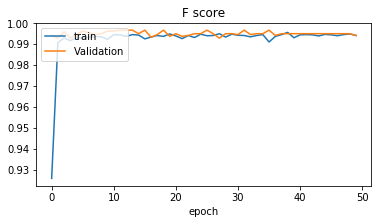

In [24]:
# summarize history for accuracy
plot_hist('acc')
# summarize history for loss
plot_hist('loss')
# summarize history for F_score
plot_f_score(history)

## Model 2

For the above analysis, our classifier labelling the majority of contracts as negative. This is because we only used extreme cases for training. As mentioned before, it would be interesting to add some more labels, to cases that are not perfect but are not evictions either. We include all the closed contract that did not involve an eviction as positive contracts.

Some overfitting is present after few epochs. We can include a higer dropout rate to fix this problem or go for an early stopping when loss starts to rise up.

In [25]:
# SLOW CELL - Preprocess of training data and check dimentions
[xtrain, ytrain,  unused_neg, 
 unused_pos]=get_train_set(medium_con,evicted_contracts,
                           unused_p_len=1,unused_n_len=1)
print(xtrain.shape, ytrain.shape, len(unused_neg), len(unused_pos))

(2148, 43, 1) (2148, 2) 1 1


In [26]:
history, model =evaluate_model(xtrain,ytrain,drop_out=0.4)

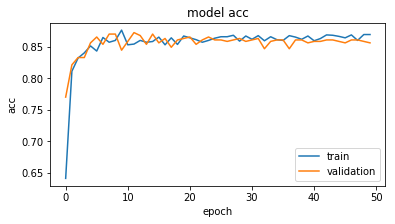

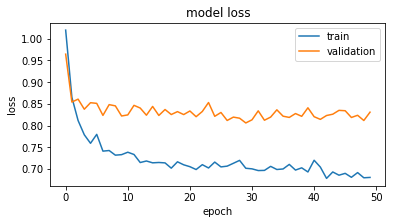

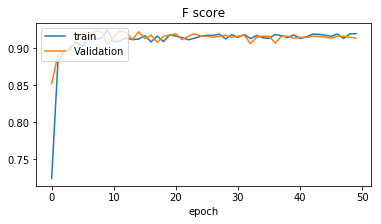

In [27]:
# summarize history for accuracy
plot_hist('acc')
# summarize history for loss
plot_hist('loss')
# summarize history for F_score
plot_f_score(history)

In [28]:
# CHECK on test set (OK!)
#np.warnings.filterwarnings('ignore')
#_=check_contracts(unused_neg)
#_=check_contracts(unused_pos)

In [2]:
#print('Unlabeled contracts predictions')
#unlabeled_contracts=list(set(contracts['contract_id'])\
#                         -set(medium_con)-set(perfect_contracts)-set(evicted_contracts))
#check=check_contracts(unlabeled_contracts)

## Model 3

Now I am going to turn my attention to tenants more then contracts. Each tenant could hold more than one contract in its past history, so I will consider the full history for each tenant_id. Moreover, I will add all the additional features that we can associate with a tenant.

Here I compute the age, the number if contracts, the number of payment method, the number of transactions and the average rent of all the contracts as numerical features. The features rent, num_transactions, age are going to be normalized between -1 and 1.
Additionaly I include the categorical features : BANK_TRANSFER, CASH, DIRECT_DEBIT, male, female.

I look at correlations between these features, and any of these can be dropped before training to test feature importance. For sake of brevity, I will use all the features at hand. A deeper analysis would require understand which features are improving the model classification.




In [20]:
# CREATE TENANT DF, ADD ALL FEATURES
unique_tenants=contracts[['tenant_id','gender','age']].drop_duplicates().set_index('tenant_id')
num_contracts=[len(map_c[tenant]) for tenant in unique_tenants.index]
unique_tenants['num_contracts']=num_contracts
num_payment_method=contracts[['tenant_id','num_payment_method',
                              'BANK_TRANSFER','CASH','DIRECT_DEBIT',
                              'rent']].groupby('tenant_id')\
.agg({'num_payment_method':'max',
     'BANK_TRANSFER':'sum',
     'CASH':'sum',
     'DIRECT_DEBIT':'sum',
     'rent':'mean'})
unique_tenants=unique_tenants.merge(num_payment_method, left_index=True,right_index=True)
unique_tenants['num_transactions'] = unique_tenants['BANK_TRANSFER']+unique_tenants['CASH']+unique_tenants['DIRECT_DEBIT']
unique_tenants['DIRECT_DEBIT']=unique_tenants['DIRECT_DEBIT'].apply(bool).apply(int)
unique_tenants['CASH']=unique_tenants['CASH'].apply(bool).apply(int)
unique_tenants['BANK_TRANSFER']=unique_tenants['BANK_TRANSFER'].apply(bool).apply(int)
unique_tenants['male']=pd.get_dummies(unique_tenants['gender'].replace({'mostly_male':'male',
                                 'mostly_female':'female',
                                 'andy':'unknown'}))['male']
unique_tenants['female']=pd.get_dummies(unique_tenants['gender'].replace({'mostly_male':'male',
                                 'mostly_female':'female',
                                 'andy':'unknown'}))['female']
unique_tenants=unique_tenants.drop('gender',axis=1)
for col in ['age','num_transactions','rent']:
    range_val=(unique_tenants[col].max() - unique_tenants[col].min())
    unique_tenants[col] = (unique_tenants[col] - unique_tenants[col].mean()) / range_val

print(unique_tenants.keys())
#unique_tenants=unique_tenants[['age','CASH','num_contracts','rent']]
unique_tenants.head(2)

Index(['age', 'num_contracts', 'num_payment_method', 'BANK_TRANSFER', 'CASH',
       'DIRECT_DEBIT', 'rent', 'num_transactions', 'male', 'female'],
      dtype='object')


,age,num_contracts,num_payment_method,BANK_TRANSFER,CASH,DIRECT_DEBIT,rent,num_transactions,male,female
tenant_id,,,,,,,,,,
CharlieJones1980-02-29,-0.196895,1,1,0,0,1,0.002172,-0.171163,1,0
MeganHarding1980-01-01,-0.196895,1,1,0,0,1,0.134131,-0.610187,0,1


Correlation between features


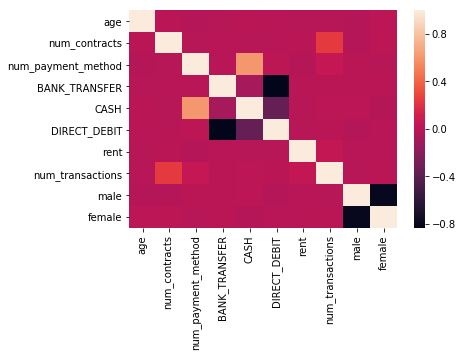

In [21]:
# calculate the correlation matrix
print('Correlation between features')
corr = unique_tenants.corr()
_=sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

In [32]:
def get_train_set_new(pos_ten,neg_ten,
                  unused_p_len=100,unused_n_len=100,
                     tenant_df=unique_tenants):
    train=[]

    unused_neg=neg_ten[-unused_n_len:]
    unused_pos=pos_ten[-unused_p_len:]

    for selected_ten in pos_ten: 
        hist=get_history(map_c[selected_ten])
        hist=hist[hist['rent_pay']==True]
        hist=list(hist['delay'])
        padding= [0] * (max_length - len(hist))
        hist=padding+hist
        hist+=list(tenant_df.loc[selected_ten,:])
        hist+=[False]
        train.append(hist)

    for selected_ten in neg_ten: 
        hist=get_history(map_c[selected_ten])
        hist=hist[hist['rent_pay']==True]
        hist=list(hist['delay'])
        padding= [0] * (max_length - len(hist))
        hist=padding+hist
        hist+=list(tenant_df.loc[selected_ten,:])
        hist+=[True]
        train.append(hist)


    df_train=pd.DataFrame(train)
    acc=[]
    label_key=df_train.keys()[-1]
    aux_keys=df_train.keys()[-tenant_df.shape[1]-1:-1]
    
    #Shuffle
    evic=df_train[df_train[label_key]==True].sample(frac=1)
    noevic=df_train[df_train[label_key]==False].sample(frac=1)

    xtrain=pd.concat([evic,noevic]).sample(frac=1)
    ytrain=xtrain[label_key].values
    ytrain = to_categorical(ytrain)
    aux_train=xtrain[aux_keys]
    
    xtrain=xtrain.drop(columns=aux_keys).drop(label_key,axis=1).values
    xtrain=np.expand_dims(xtrain, axis=2)
    
    return xtrain, ytrain, aux_train, unused_neg, unused_pos

In [33]:
pos_ten=list(set(contracts[(~contracts['contract_end'].isna())&\
                           (contracts['eviction'].isna())]['tenant_id']))
neg_ten=list(set(contracts[(~contracts['contract_end'].isna())&\
                           (~contracts['eviction'].isna())]['tenant_id']))

In [ ]:
[xtrain, ytrain, aux_train,
 unused_neg, unused_pos]=get_train_set_new(pos_ten, neg_ten, 
                                           unused_p_len=400, unused_n_len=100,)

In [ ]:
print(xtrain.shape, ytrain.shape, aux_train.shape, 
 len(unused_neg), len(unused_pos))

In [ ]:
# Model 2

aux_train=np.array(aux_train)
aux_dim=aux_train.shape[1]

n_timesteps, n_features, n_outputs = xtrain.shape[1], xtrain.shape[2], ytrain.shape[1]

verbose= 0
lsmr_para=20
epochs=20
batch_size=64
drop_out=0.5
dense_size=100
dense_layer_num=2

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
main_input = Input(shape=(n_timesteps,n_features,), dtype='float32', name='main_input')
lstm_out = LSTM(lsmr_para,dropout=drop_out)(main_input)

auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)
auxiliary_input = Input(shape=(aux_dim,), name='aux_input')
x = keras.layers.concatenate([lstm_out, auxiliary_input])

for _ in range(dense_layer_num):
    x = Dense(dense_size, activation='relu')(x)

main_output = Dense(n_outputs, activation='softmax', name='main_output')(x)
model = Model(inputs=[main_input, auxiliary_input], outputs=main_output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall()]
             )
classes_in=sum(ytrain)
weight=classes_in[0]/classes_in[1]
    
    
history=model.fit([xtrain, np.array(aux_train)], ytrain,
                  validation_split=0.2,
          epochs=epochs, batch_size=batch_size,
          verbose=0,class_weight={0: 1., 1: weight})

In [ ]:
# summarize history for accuracy, loss and f-score
plot_hist('acc')
plot_hist('loss')
plot_f_score(history)

In [ ]:
# Visualization of the new architecture
plot_model(model, to_file='model_2_plot.png', show_shapes=True, show_layer_names=True,rankdir='LR')
img=Image.open('model_2_plot.png')
img

In [ ]:
# Test sets

predictions=[]
prints_list=['Bad Tenants','Good Tenants']
for i, unused_set in enumerate([unused_neg,unused_pos]):
    print(prints_list[i])
    for tenant in unused_set:
        temp=get_history(map_c[tenant])
        temp=list(temp[temp['rent_pay']==True]['delay'])
        x_pred=[0]*(max_length-len(temp))+temp
        x_pred=np.expand_dims(np.expand_dims(x_pred, axis=0), axis=2)
        aux_pred=np.array(unique_tenants.loc[tenant,:])
        aux_pred=np.expand_dims(aux_pred, axis=0)
        predictions.append(model.predict([x_pred,aux_pred]))
    check=[predictions[i][0][0]-predictions[i][0][1] for i in range(len(predictions))]
    plt.figure(figsize=(6,3))
    _,_,_=plt.hist(check)
    plt.show()

# Using clustering for labelling - Model 4

Here I tried to expand the labeled data by using an unsupervised classifier. I used the mean values of (mean, max and standard_deviation) for the previous two classes (evicted and closed+perfect contracts). KMeans, returns a set of labels, and distances from the centroids. I then take the labels that are near (one std) to the centroids as true, and use them for trainig. This way I label only tenats that behave, in a statistical way, very similarly to the already established classes. This model will be more robust and have more data to get information from.

Here class 0 will be associated with bed tenants, and class 1 with good tenants. Below I print the results of this classification. Once can see that all perfect tenants gets a correct labelling. The Evicted tenants, are well clustered except few examples 42(13%). The latter are often cases of evictions where the neant did not delay much its payments (there are also few cases of perfect tenants that have been evicted). Majority of closed cases (84%) also get classified correctly, except 266 (15%) of them.

In [27]:
# Add statistical info about each tenant history 

unique_tenants_temp=unique_tenants.copy()

tenant_mean=[]
tenant_std=[]
tenant_sum=[]
tenant_max=[]

for tenant in unique_tenants_temp.index:
    hist=get_history(map_c[tenant])
    hist=hist[hist['rent_pay']==True]['delay']
    tenant_mean.append(hist.mean())
    tenant_sum.append(hist.sum())
    tenant_std.append(hist.std())
    tenant_max.append(hist.max())
    
unique_tenants_temp['mean_hist']=tenant_mean
unique_tenants_temp['std_hist']=tenant_std
unique_tenants_temp['sum_hist']=tenant_sum
unique_tenants_temp['max_hist']=tenant_max

In [28]:
# Uses KMeans to create two clusters

X=unique_tenants_temp[['mean_hist','std_hist','max_hist']].fillna(0).to_numpy()

# Sets the init of the KMeans as the average of eviction cases, 
# and the average of perfect+closed cases

# Eviction Averages
type_1=contracts[~(contracts['eviction'].isna())]['contract_id']
bad=list(transactions[transactions['contract_id'].isin(type_1)]\
.groupby('contract_id').agg({'delay':['mean','std','max']}).mean())

# Perfect Averages + Closed
type_na=contracts[((~contracts['contract_end'].isna())&(contracts['eviction'].isna()))|\
                  (contracts['perfect']==True)]['contract_id']
good=list(transactions[transactions['contract_id'].isin(type_na)]\
.groupby('contract_id').agg({'delay':['mean','std','max']}).mean())

# Creates clusters
kmeans = KMeans(n_clusters=2, random_state=0,
               init=np.array([bad,good])).fit(X)
print('class 0:',sum(kmeans.labels_==0))
print('class 1:',sum(kmeans.labels_==1))

class 0: 1748
class 1: 8203


In [29]:
# Check clusterization for our known classes

unique_tenants_temp['cluster']=kmeans.labels_

temp=contracts[['tenant_id','contract_end','eviction','perfect']].set_index('tenant_id')
temp['contract_end']=temp['contract_end'].notnull().astype('int')
temp['eviction']=(~temp['eviction'].isna()).astype('int')
temp=temp.reset_index().groupby('tenant_id').agg({'eviction':'max',
                                                 'contract_end':'max',
                                                 'perfect':'min'})
unique_tenants_temp=unique_tenants_temp.merge(temp,left_index=True,right_index=True)

alldistances = kmeans.fit_transform(X)
unique_tenants_temp['distance_0']=alldistances[:,0]
unique_tenants_temp['distance_1']=alldistances[:,1]
unique_tenants_temp['distance_min']=unique_tenants_temp[['distance_0','distance_1']].min(axis=1)

print('Evictions classified by Kmeans')
print('class 0:',len(unique_tenants_temp[(unique_tenants_temp['eviction']==1)&(unique_tenants_temp['cluster']==0)]))
print('class 1:',len(unique_tenants_temp[(unique_tenants_temp['eviction']==1)&(unique_tenants_temp['cluster']==1)]))
print('Closed  classified by Kmeans')
print('class 0:',len(unique_tenants_temp[(unique_tenants_temp['contract_end']==1)&(unique_tenants_temp['eviction']==0)\
                    &(unique_tenants_temp['cluster']==0)]))
print('class 1:',len(unique_tenants_temp[(unique_tenants_temp['contract_end']==1)&(unique_tenants_temp['eviction']==0)\
                    &(unique_tenants_temp['cluster']==1)]))
print('Perfect  classified by Kmeans')
print('class 0:',len(unique_tenants_temp[(unique_tenants_temp['perfect']==1)&(unique_tenants_temp['cluster']==0)]))
print('class 1:',len(unique_tenants_temp[(unique_tenants_temp['perfect']==1)&(unique_tenants_temp['cluster']==1)]))

Evictions classified by Kmeans
class 0: 273
class 1: 42
Closed  classified by Kmeans
class 0: 266
class 1: 1437
Perfect  classified by Kmeans
class 0: 0
class 1: 5216


In [ ]:
print('Eviction cases, clustered as good tenants')
unique_tenants_temp[(unique_tenants_temp['eviction']==1)&(unique_tenants_temp['cluster']==1)].sort_values('max_hist').head(2)

In [ ]:
# Label only tenants near to the centroids found by clustering
min_std=unique_tenants_temp['distance_min'].std()
unique_tenants_temp['labeled']=True
unique_tenants_temp.loc[unique_tenants_temp['distance_min']>min_std,'labeled']=False

In [ ]:
# calculate the correlation matrix
print('Correlation between features')
corr = unique_tenants_temp.corr()
_=sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)

In [ ]:
pos_ten=unique_tenants_temp[unique_tenants_temp['labeled']==True]
pos_ten=list(pos_ten[(pos_ten['eviction']==0)|(pos_ten['cluster']==1)].index)

neg_ten=unique_tenants_temp[unique_tenants_temp['labeled']==True]
neg_ten=list(neg_ten[(neg_ten['eviction']==1)|(neg_ten['cluster']==0)].index)
neg_ten=neg_ten+list(unique_tenants_temp[(unique_tenants_temp['eviction']==1)].index)

print('Good Tenants:',len(pos_ten),'Bad Tenants:',len(neg_ten))

In [ ]:
unique_tenants_temp=unique_tenants_temp[['age', 
                    'num_contracts',
                    'num_payment_method',
                    'BANK_TRANSFER', 'CASH',
                    'DIRECT_DEBIT', 'rent', 
                    'num_transactions']]

In [ ]:
[xtrain, ytrain, aux_train,  
 unused_neg, unused_pos]=get_train_set_new(pos_ten, neg_ten, 
                                           unused_p_len=1000, unused_n_len=100,
                                          tenant_df=unique_tenants_temp)

In [ ]:
print(xtrain.shape, ytrain.shape, aux_train.shape,
 len(unused_neg), len(unused_pos))

In [ ]:

aux_train=np.array(aux_train)
aux_dim=aux_train.shape[1]

n_timesteps, n_features, n_outputs = xtrain.shape[1], xtrain.shape[2], ytrain.shape[1]

verbose= 0
lsmr_para=20
epochs=40
batch_size=64
drop_out=0.1
dense_size=100
dense_layer_num=2

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
main_input = Input(shape=(n_timesteps,n_features,), dtype='float32', name='main_input')
lstm_out = LSTM(lsmr_para,dropout=drop_out)(main_input)

auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)
auxiliary_input = Input(shape=(aux_dim,), name='aux_input')
x = keras.layers.concatenate([lstm_out, auxiliary_input])

for _ in range(dense_layer_num):
    x = Dense(dense_size, activation='relu')(x)

main_output = Dense(n_outputs, activation='softmax', name='main_output')(x)
model = Model(inputs=[main_input, auxiliary_input], outputs=main_output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',keras_metrics.precision(), keras_metrics.recall()]
             )
classes_in=sum(ytrain)
weight=classes_in[0]/classes_in[1]
    
    
history=model.fit([xtrain, np.array(aux_train)], ytrain,
                  validation_split=0.2,
          epochs=epochs, batch_size=batch_size,
          verbose=0,class_weight={0: 1., 1: weight})

In [ ]:
# summarize history for accuracy, loss and f-score
plot_hist('acc')
plot_hist('loss')
plot_f_score(history)

In [ ]:
# Test sets

predictions=[]
prints_list=['Bad Tenants','Good Tenants']
for i, unused_set in enumerate([unused_neg,unused_pos]):
    print(prints_list[i])
    for tenant in unused_set:
        temp=get_history(map_c[tenant])
        temp=list(temp[temp['rent_pay']==True]['delay'])
        x_pred=[0]*(max_length-len(temp))+temp
        x_pred=np.expand_dims(np.expand_dims(x_pred, axis=0), axis=2)
        aux_pred=np.array(unique_tenants_temp.loc[tenant,:])
        aux_pred=np.expand_dims(aux_pred, axis=0)
        predictions.append(model.predict([x_pred,aux_pred]))
    check=[predictions[i][0][0]-predictions[i][0][1] for i in range(len(predictions))]
    plt.figure(figsize=(6,3))
    _,_,_=plt.hist(check)
    plt.show()

# Time dependent predictions - Model 5

The above models, can be used in an arbitrary date, by looking at data avaliable till that specific date.
Here I builted a function that modifies the dataframes as for a set present date. Training can be done with the information avaliable till the date, but clearly the model will not have enough data to train on if the dataset is small. Here I tested the Model2 with a date 12 month earlier of the last date in the full dataset.

In [ ]:
def update_df(present_date,print_please=False):
    contracts_present=all_contracts.copy()
    transactions_present=all_transactions.copy()

    # remove end dates later than present
    contracts_present.loc[contracts_present['contract_end']>present_date,'contract_end']=np.nan
    contracts_present.loc[contracts_present['contract_end']>present_date,'eviction']=np.nan
    #remove start dates later than present
    contracts_present=contracts_present[contracts_present['contract_start']<present_date]

    # remove future transactions and future contracts
    transactions_present=transactions_present[transactions_present['Payment_date']<present_date]
    transactions_present=transactions_present[transactions_present['contract_id']\
                                              .isin(contracts_present['contract_id'])]

    # redefine the classed using the date. Perfect contracts will stay the same
    evicted_contracts=contracts_present[(~contracts_present['eviction'].isna())&(~contracts_present['contract_end'].isna())]['contract_id'].tolist()
    medium_con=contracts_present[(contracts_present['eviction'].isna())&(~contracts_present['contract_end'].isna())]['contract_id'].tolist()
    perfect_contracts=all_contracts[all_contracts['perfect']==True]['contract_id'].tolist()
    perfect_contracts=list(set(perfect_contracts).intersection(set(contracts_present['contract_id'])))
    
    contracts=contracts_present
    transactions=transactions_present
    
    if print_please:
        print('evicted_contracts',len(evicted_contracts))
        print('medium_con',len(medium_con))
        print('perfect_contracts',len(perfect_contracts))
        print('Number of contracts', len(contracts))
    return len(evicted_contracts),len(medium_con),len(perfect_contracts),len(contracts)

In [ ]:
# Shows trend of classes in time
dates=[]
delta = last_date - first_date         
for i in range(delta.days + 1):
    dates.append(first_date + timedelta(i))
plot_dates=[]
for date in dates[::30]:
    plot_dates.append(update_df(date))
_=pd.DataFrame(plot_dates,index=dates[::30]).rename(columns={0:'Evictions',
                                          1:'Closed',
                                          2:'Perfect',
                                          3:'Total'}).plot(logy=True)

In [ ]:
present_date='2016-12-31'

max_length=max(transactions['index_history_tenant'])+1
update_df(present_date)

In [ ]:
# SLOW CELL - Preprocess of training data and check dimentions
[xtrain, ytrain,  unused_neg, 
 unused_pos]=get_train_set(medium_con,evicted_contracts,unused_p_len=200,unused_n_len=50)
print(xtrain.shape, ytrain.shape, len(unused_neg), len(unused_pos))

In [ ]:
history, model=evaluate_model(xtrain,ytrain)

In [ ]:
#np.warnings.filterwarnings('ignore')
print('Negative Test Set')
_=check_contracts(unused_neg,max_ran=max_length)
print('Positive Test Set')
_=check_contracts(unused_pos,max_ran=max_length)
print('Unlabeled contracts predictions')
unlabeled_contracts=list(set(contracts['contract_id'])\
                         -set(medium_con)-set(evicted_contracts))
check=check_contracts(unlabeled_contracts,max_ran=max_length)

In [ ]:
# summarize history for accuracy
plot_hist('acc')
# summarize history for loss
plot_hist('loss')
# summarize history for F_score
plot_f_score(history)

# Isolation Forest Classification

Automatically created module for IPython interactive environment
True Negatives 1
True Positives 4
True Negatives 1
True Positives 4
True Negatives 1
True Positives 4
True Negatives 2
True Positives 3
True Negatives 274
True Positives 41
True Negatives 258
True Positives 57
True Negatives 284
True Positives 31
True Negatives 163
True Positives 152


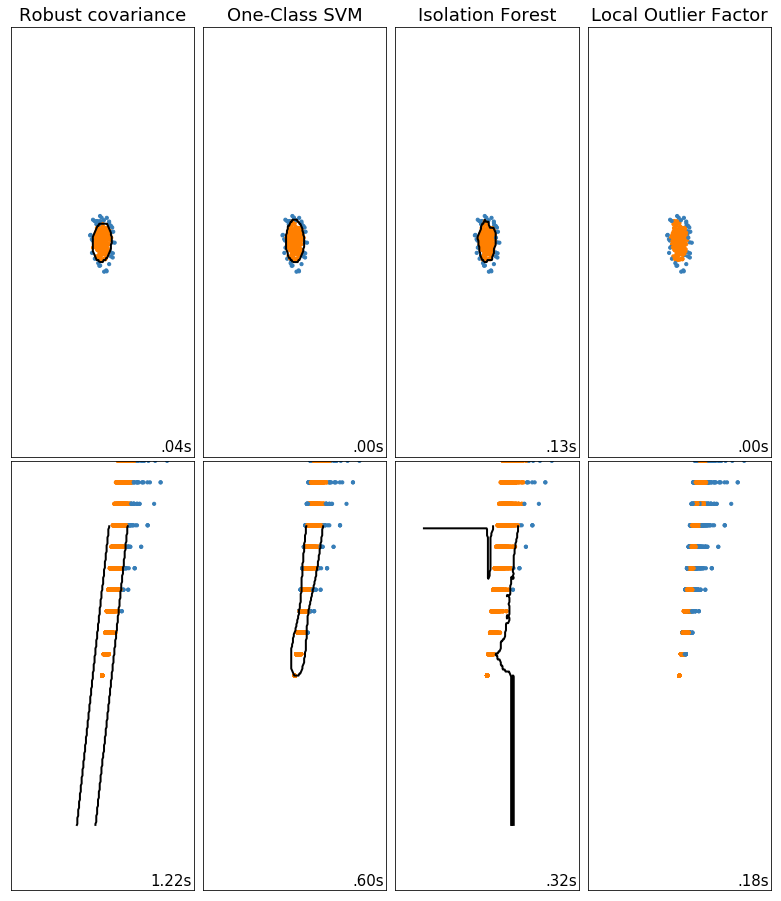

In [31]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
   ("Isolation Forest", IsolationForest(
                                         contamination=outliers_fraction,
                                         random_state=42)),
   ("Local Outlier Factor", LocalOutlierFactor(
       n_neighbors=35, contamination=outliers_fraction))]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    unique_tenants_temp[['std_hist','max_hist']].dropna().to_numpy()]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    #X = np.concatenate([X, rng.uniform(low=-6, high=6,
    #                   size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
        
        predictions=pd.Series(y_pred==-1)
        evictions=unique_tenants_temp[['std_hist','max_hist','eviction']].dropna()['eviction'].reset_index(drop=True)
        print("True Negatives",sum(predictions[evictions==1]))
        print("True Positives",sum(~predictions[evictions==1]))

plt.show()

In [120]:
import itertools

In [277]:
true_pos=[]

for i in range(len(c)):
    this_set=list(c[i])
    iso_forest=IsolationForest(contamination=outliers_fraction,random_state=42)
    X_temp=unique_tenants_temp[list(this_set)].fillna(0)
    X=X_temp.to_numpy()
    pred=iso_forest.fit(X).predict(X)
    predictions=pd.Series(pred==-1)
    #print(sum(~predictions))
    #print(sum(predictions))
    evictions=unique_tenants_temp['eviction'].reset_index(drop=True)
    #print(len(predictions))
    true_pos.append(sum(~predictions[evictions==1]))
    #print(top_list[i])
    #print(true_pos[-1])
    #pred=pd.DataFrame(pred).rename(columns={0:'Pred'})
    #pd.concat([pd.DataFrame(X),pred],axis=1)
    #final=pd.concat([X_temp.reset_index(),pred],axis=1)
    #final=pd.concat([final,evictions],axis=1)
    #final[final['eviction']==1]

In [278]:
pd.set_option('display.max_colwidth', 2000)
pd.DataFrame([true_pos,c]).T.sort_values(0).reset_index(drop=True)[:20]

,0,1
0,15,"(num_payment_method, sum_hist, mean_hist, std_hist, max_hist)"
1,19,"(age, num_payment_method, mean_hist, std_hist, max_hist)"
2,19,"(age, num_payment_method, sum_hist, mean_hist, std_hist)"
3,23,"(num_payment_method, mean_hist, std_hist, DIRECT_DEBIT, max_hist)"
4,24,"(num_payment_method, sum_hist, mean_hist, std_hist, DIRECT_DEBIT)"
5,25,"(age, num_payment_method, sum_hist, mean_hist, max_hist)"
6,26,"(num_payment_method, mean_hist, std_hist, CASH, max_hist)"
7,26,"(age, num_payment_method, rent, mean_hist, std_hist)"
8,26,"(num_payment_method, rent, mean_hist, std_hist, max_hist)"
9,26,"(num_payment_method, sum_hist, rent, mean_hist, std_hist)"


In [240]:
top_list=list(pd.DataFrame([true_pos,c[:len(true_pos)]]).T.sort_values(0)[:20][1])

In [ ]:
### best choice with 5 features (15)
### best choice with 4 features (14)
### best choice ['num_payment_method', 'std_hist', 'max_hist'] with 2 or 3 features (17)

In [181]:
this_set=['num_payment_method', 'std_hist', 'max_hist']
iso_forest=IsolationForest(contamination=outliers_fraction,random_state=42)
X_temp=unique_tenants_temp[list(this_set)].fillna(0)
X=X_temp.to_numpy()
pred=iso_forest.fit(X).predict(X)
predictions=pd.Series(pred==-1)
evictions=unique_tenants_temp[['age','num_transactions','CASH','mean_hist',
                               'std_hist', 'max_hist','eviction']]['eviction'].reset_index(drop=True)
#print(len(predictions))
true_pos.append(sum(~predictions[evictions==1]))
#print(top_list[i])
#print(true_pos[-1])
#pred=pd.DataFrame(pred).rename(columns={0:'Pred'})
#pd.concat([pd.DataFrame(X),pred],axis=1)
#final=pd.concat([X_temp.reset_index(),pred],axis=1)
#final=pd.concat([final,evictions],axis=1)
#final[final['eviction']==1]

In [196]:
X_temp['pred']=pred

In [223]:
selected_bad_tenants=unique_tenants_temp.loc[X_temp[X_temp['pred']==-1].index,:]

In [234]:
print('Total evictions: 315')
print('Selected:',sum(selected_bad_tenants['eviction']))

Total evictions: 315
Selected: 298


In [235]:
print('Perfect:',sum(selected_bad_tenants['perfect']))

Perfect: 7


# AUTOENCODER

In [164]:
from sklearn.preprocessing import normalize

temp=unique_tenants_temp[unique_tenants_temp['eviction']==0]
good_tenants=list(temp[temp['contract_end']==1].index)
good_tenants+=list(temp[temp['perfect']==1].index)
len(good_tenants)

long_seq=[]
for ten in good_tenants:
    sequence=get_history(map_c[ten])
    sequence=list(sequence[sequence['rent_pay']==True]['delay'])
    sequence=np.array([0]*(max_length-len(sequence))+sequence)
    sequence = normalize(sequence[:,np.newaxis], axis=0).ravel()
    long_seq.append(sequence)
sequences=np.array(long_seq)
n_data, n_in = sequences.shape
sequences = sequences.reshape((n_data, n_in, 1))

sequences.shape

(6919, 43, 1)

In [165]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
# define input sequence
# reshape input into [samples, timesteps, features]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
history=model.fit(sequences, sequences, epochs=50, verbose=0)
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')
# demonstrate recreation
#yhat = model.predict(sequence, verbose=0)

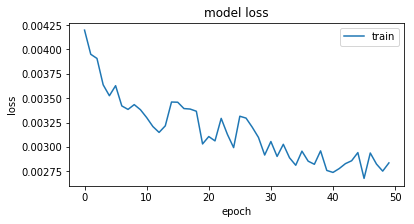

In [186]:
plot_hist('loss')

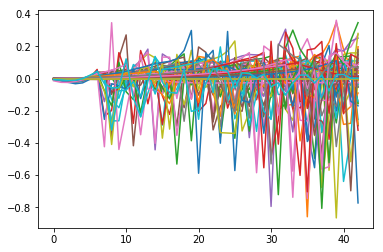

In [166]:
for i in range(100):
    test_imput=sequences[i:i+1,:,:]
    plt.plot(np.squeeze(model.predict(test_imput, verbose=0))-np.squeeze(test_imput))

In [167]:
bad_tenants=unique_tenants_temp[unique_tenants_temp['eviction']==1].index
print(len(bad_tenants))

long_seq=[]
for ten in bad_tenants:
    sequence=get_history(map_c[ten])
    sequence=list(sequence[sequence['rent_pay']==True]['delay'])
    sequence=np.array([0]*(max_length-len(sequence))+sequence)
    sequence = normalize(sequence[:,np.newaxis], axis=0).ravel()
    long_seq.append(sequence)
bad_sequences=np.array(long_seq)
n_data, n_in = bad_sequences.shape
bad_sequences = bad_sequences.reshape((n_data, n_in, 1))
bad_sequences.shape

315


(315, 43, 1)

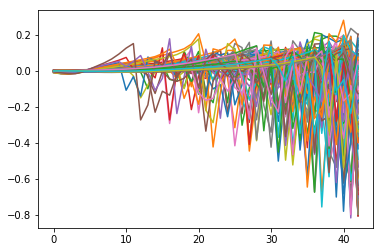

In [168]:
for i in range(100):
    test_imput=bad_sequences[i:i+1,:,:]
    plt.plot(np.squeeze(model.predict(test_imput, verbose=0))-np.squeeze(test_imput))

In [247]:
threshold=0.005

Bad


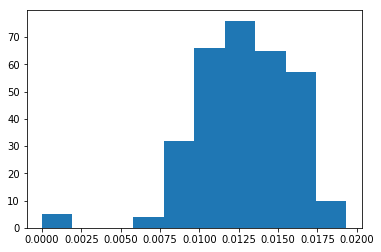

In [179]:
mse_list_bad=[]
for i in range(315):
    test_imput=bad_sequences[i:i+1,:,:]
    A=np.squeeze(model.predict(test_imput, verbose=0))
    B=np.squeeze(test_imput)
    mse_list_bad.append((np.square(A - B)).mean())
plt.hist(mse_list_bad)
print('Bad')

In [248]:
print('True Negatives % ')
len([a for a in mse_list_bad if a > threshold])/len( mse_list_bad)

True Negatives % 


0.9841269841269841

Good


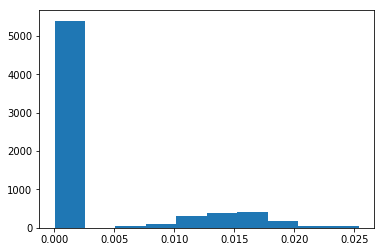

In [175]:
mse_list=[]
skip=0
for i in range(skip,skip+6918):
    test_imput=sequences[i:i+1,:,:]
    A=np.squeeze(model.predict(test_imput, verbose=0))
    B=np.squeeze(test_imput)
    mse_list.append((np.square(A - B)).mean())
plt.hist(mse_list)
print('Good')

In [249]:
print('True Positives %')
len([a for a in mse_list if a < threshold])/len( mse_list)

True Positives %


0.7794160161896502

In [193]:
temp=unique_tenants_temp[unique_tenants_temp['eviction']==0]
nolabel_tenants=list(temp[(temp['contract_end']==0)&(temp['perfect']==0)].index)
len(nolabel_tenants)

long_seq=[]
for ten in nolabel_tenants:
    sequence=get_history(map_c[ten])
    sequence=list(sequence[sequence['rent_pay']==True]['delay'])
    sequence=np.array([0]*(max_length-len(sequence))+sequence)
    sequence = normalize(sequence[:,np.newaxis], axis=0).ravel()
    long_seq.append(sequence)
nolabel_sequences=np.array(long_seq)
n_data, n_in = nolabel_sequences.shape
nolabel_sequences = nolabel_sequences.reshape((n_data, n_in, 1))

nolabel_sequences.shape

(3633, 43, 1)

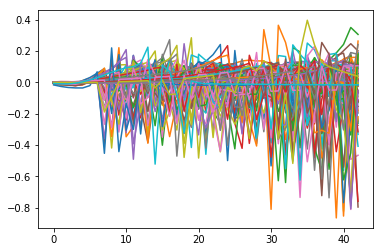

In [194]:
for i in range(100):
    test_imput=nolabel_sequences[i:i+1,:,:]
    plt.plot(np.squeeze(model.predict(test_imput, verbose=0))-np.squeeze(test_imput))

No Label


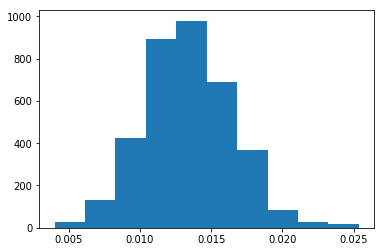

In [196]:
mse_list_nolabel=[]
for i in range(3633):
    test_imput=nolabel_sequences[i:i+1,:,:]
    A=np.squeeze(model.predict(test_imput, verbose=0))
    B=np.squeeze(test_imput)
    mse_list_nolabel.append((np.square(A - B)).mean())
plt.hist(mse_list_nolabel)
print('No Label')

In [250]:
print('No labels %')
print('Good',len([a for a in mse_list_nolabel if a < threshold])/len( mse_list_nolabel))
print('Bad',len([a for a in mse_list_nolabel if a > threshold])/len( mse_list_nolabel))

No labels %
Good 0.002202036884117809
Bad 0.9977979631158822


Random Labels


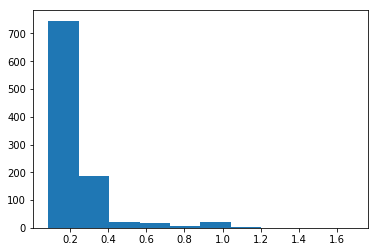

In [252]:
# Test a random sequence
#test_imput=np.array([np.array([[1]]*43)])
mse_random=[]
for i in range(1000):
    test_imput=np.random.rand(1, 43, 1)
    A=np.squeeze(model.predict(test_imput, verbose=0))
    B=np.squeeze(test_imput)
    mse_random.append((np.square(A - B)).mean())
plt.hist(mse_random)
print('Random Labels')

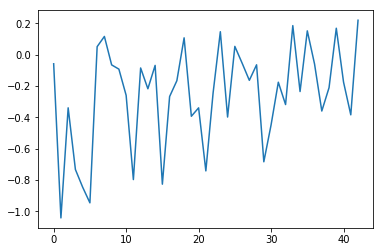

In [263]:
test_imput=np.random.rand(1, 43, 1)
plt.plot(np.squeeze(model.predict(test_imput, verbose=0))-np.squeeze(test_imput))

In [253]:
print('Random cases %')
print('Good',len([a for a in mse_random if a < threshold])/len( mse_random))
print('Bad',len([a for a in mse_random if a > threshold])/len( mse_random))

Random cases %
Good 0.0
Bad 1.0


Most unseen cases are considered anomalies, this clearly would not work in a general case.

# Conclusion and Improvements

I have implemented a variety of models to study the problem. Starting from an extreme cases model, to a more stable and reliable model. I also included additional features outside of the history of transactions to classify tenants (rather then single contracts). Finally I gave a possible take to a time dependent solution.

There are many ways to improve and modify my analysis, here I point out at few ideas that, because of lack of time, I did not implement.

### Anomaly Detection

I decided to use a stardard approach in NN for unbalanced classes. Here I simply included weights into our fitting function. Considering that the set is strongly unbalanced, I could have considered it as an anomaly detection problem. There are many standard ML methods to deal with this kind of problems (SK-Learn librabry), and few NN methods (Autoencoders) that could be implemented.

### Feature selection and hyperparameters

The reign of feature selection and hyperparameter search is vast, and often time-consuming. A selection method could be done by training the model with some limited set of features and compare metrics to find the strongest ones. Similarly, for the hyperparameter, methods like grid search, or random search would be useful to tune correctly our NN. 

### Alternative Architectures

I decided to use a somehow strightforward architecture for the NN, as I am confortable with the structure, and have an understanding of all its parts. More intricated and advanced architectures could be implemented. Often the best way to find a good structure is by reading some papers and studies that solved a similar problem and test them on the dataset at hand. 

## The End

I hope my presentation was not too long, nor too shallow. If any of the material is unclear, I am happy to discuss any question you might have. 

Best,

Paco Giudice